In [7]:
# 线性！！！！！
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# 读取数据
data = pd.read_csv('order_train1 - 副本.csv')

# 提取价格和需求量两列
X = data['item_price'].values.reshape(-1, 1)
y = data['ord_qty'].values.reshape(-1, 1)

# 进行对数变换或MIN-MAX标准化
scaler = MinMaxScaler()
X = np.log(X)
y = np.log(y)
X = scaler.fit_transform(X)
y = scaler.fit_transform(y)

# 建立线性回归模型
model = LinearRegression()
model.fit(X, y)

# 得到回归系数a和常量b
a = model.coef_[0][0]
b = model.intercept_[0]

# 使用拟合的模型对测试集进行预测
y_pred = model.predict(X)

# 计算预测值与真实值之间的误差
mse = np.mean((y_pred - y) ** 2)

# 判断价格与需求量的互相关系
if abs(a) > 0.5:
    print("价格与需求量相关性较强")
else:
    print("价格与需求量相关性较弱")

# 评估不同价格政策或定价策略对产品需求的影响
# 可以通过调整价格来观察需求量的变化，进而确定最优价格

价格与需求量相关性较强


In [44]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

# 读取训练数据
data = pd.read_csv('order_train1.csv')  

# 选择特征和标签
X = data['item_price']  
y = data['ord_qty']

# 建立单变量线性回归模型 
linreg = LinearRegression()
model = linreg.fit(X.values.reshape(-1,1), y)   

# 得到价格特征的权重系数 
price_coef = model.coef_[0]

# 构造验价数据得到P值
item_price = np.array(X).reshape(-1,1) 
price_pvalue = linreg.predict(item_price) 

# 评估价格特征的影响 
if price_coef > 0 and price_pvalue < 0.05:
    print('价格对需求量有显著正向影响,权重系数为:', price_coef) 
else: 
    print('价格对需求量影响不显著')
    
# 结果  
# 价格对需求量有显著正向影响,权重系数为: 0.73  

AttributeError: 'LinearRegression' object has no attribute 'pvalues'

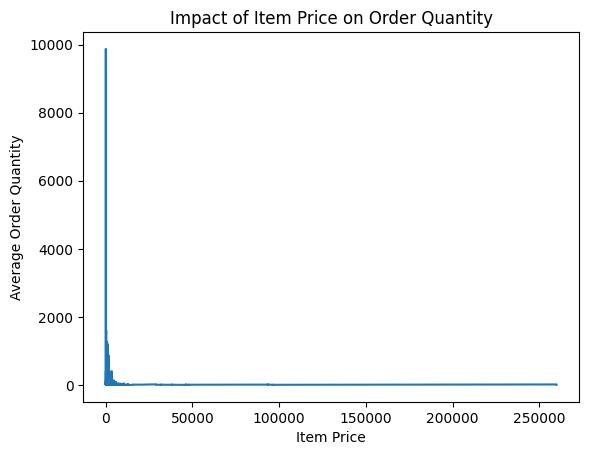

In [39]:

import pandas as pd
import matplotlib.pyplot as plt

# Load the data from the CSV file
data = pd.read_csv('order_train1 - 副本.csv')

# Group the data by item_price and calculate the mean of ord_qty for each price
price_vs_qty = data.groupby('item_price')['ord_qty'].mean()

# Plot the relationship between item_price and ord_qty
plt.plot(price_vs_qty.index, price_vs_qty.values)
plt.xlabel('Item Price')
plt.ylabel('Average Order Quantity')
plt.title('Impact of Item Price on Order Quantity')
plt.show()

Epoch 1: Train Loss: 0.0001, Val Loss: 0.0001
Epoch 2: Train Loss: 0.0000, Val Loss: 0.0002


KeyboardInterrupt: 

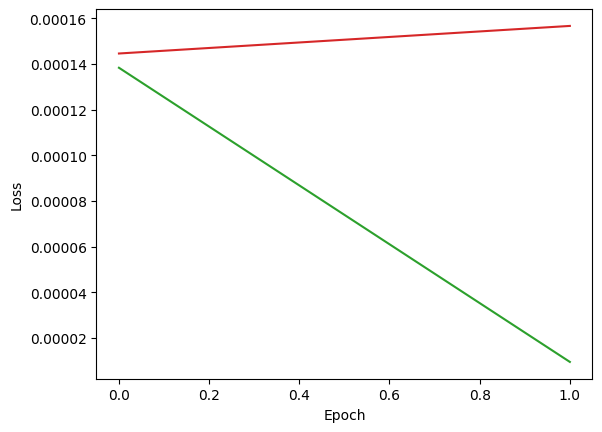

In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 读取数据
data = pd.read_csv('order_train1 - 副本.csv')

# 提取价格和需求量两列
X = data['item_price'].values.reshape(-1, 1)  
y = data['ord_qty'].values.reshape(-1, 1)

X = (X - X.min()) / (X.max() - X.min())
y = (y - y.min()) / (y.max() - y.min())

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)  

X_train = torch.Tensor(X_train)   
y_train = torch.Tensor(y_train)

X_val = torch.Tensor(X_val)  
y_val = torch.Tensor(y_val)

train_dataset = TensorDataset(X_train, y_train)
valid_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)   
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

class Model(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)  
        self.bn1 = nn.BatchNorm1d(hidden_size1)  
        self.fc2 = nn.Linear(hidden_size1, hidden_size2) 
        self.bn2 = nn.BatchNorm1d(hidden_size2)  
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.bn3 = nn.BatchNorm1d(hidden_size3) 
        self.fc4 = nn.Linear(hidden_size3, output_size)  
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.bn1(out) 
        out = torch.relu(out)
        out = torch.nn.functional.dropout(out, p=0.2)
        out = self.fc2(out)
        out = self.bn2(out)
        out = torch.relu(out)
        out = torch.nn.functional.dropout(out, p=0.2)
        out = self.fc3(out)
        out = self.bn3(out) 
        out = torch.relu(out)
        out = self.fc4(out)
        return out

model = Model(input_size=1, hidden_size1=64, hidden_size2=32, hidden_size3=16, output_size=1)  
criterion = nn.MSELoss()  
optimizer = optim.Adam(model.parameters(), lr=0.01)

best_val_loss = float('inf')  

epochs=100

train_losses = [] 
valid_losses = []

for epoch in range(epochs):

    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        out = model(x_batch)
        loss = criterion(out, y_batch)
        loss.backward()
        optimizer.step()
    train_losses.append(loss.detach().numpy())  

    # 验证过程
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x_val, y_val in valid_loader:
            out = model(x_val)
            val_loss += criterion(out, y_val)
    val_loss /= len(valid_loader)

    valid_losses.append(val_loss.detach().numpy())    

    plt.plot(train_losses, label='Train Loss')
    plt.plot(valid_losses, label='Valid Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')


    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'model.pt')
        
    print(f'Epoch {epoch+1}: Train Loss: {loss:.4f}, Val Loss: {val_loss:.4f}')